# Noções de IA - Trabalho Final - Deep Learning for Chess
##### Integrantes:
- Lucas Corrêa Boaventura           - 211038262
- Alexandre Castanho Sampaio Rocha  - 211027536

## Bibliotecas

In [321]:
import tensorflow as tf
from tensorflow.keras import layers
import chess
import pandas as pd
import numpy as np
import pickle
from random import randint
import chess.engine
engine = chess.engine.SimpleEngine.popen_uci("stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2")
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


## Dados para trabalhar com um Tabuleiro

#### Funções

['PAWN', 'KNIGHT', 'BISHOP', 'ROOK', 'QUEEN', 'KING'] 
 ['BLACK', 'WHITE'] 
 ['p', 'n', 'b', 'r', 'q', 'k']


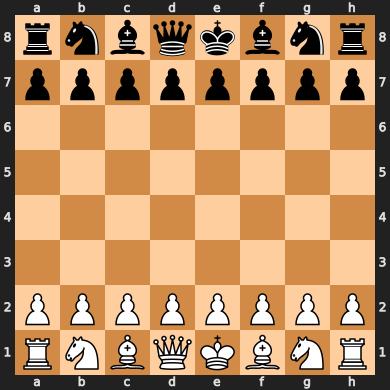

In [322]:
def getPieceMaskBoard(piece, color):
    maps = chess.Board().pieces_mask(piece, color)
    maps = list(bin(maps)[2:])
    return np.reshape(np.array([0 for _ in range(64-len(maps))]+maps, dtype=np.int8), (8, 8))[:,::-1]

def getBoard(board:list, piece:str, repr:str, color=0) -> chess.Board:
    fen=''
    for i in range(8):
        count = 0
        for j in range(8):
            v = board[i][j]
            if v == 0:
                count += 1
            else:
                if count != 0:
                    fen += str(count)
                    count = 0
                if repr == 'single': fen += [piece if color==0 else piece.upper()][0]
                elif repr == 'double': fen += [piece if v < 0 else piece.upper()][0]
        if count != 0 :
            fen += str(count)
        fen+='/'
    return chess.Board(fen[:-1])

def getSquareName(position:list) -> str: # position deve ser 'ONE-HOT', apenas uma peça
    position = position[:,::-1].flatten()
    square = 63 - list(position).index(1)
    return chess.square_name(square)

pieces_names = [piece.upper() for piece in chess.PIECE_NAMES[1:]]
pieces_colors = [color.upper() for color in chess.COLOR_NAMES]
pieces_symbols = chess.PIECE_SYMBOLS[1:]
print(pieces_names,'\n',
      pieces_colors,'\n',
      pieces_symbols
)
chess.Board()

#### 12 Matrizes 

In [323]:
#data = np.array([[[0 for _ in range(8)] for _ in range(8)] for _ in range(12)], dtype=np.int8)
#
#for i in range(len(pieces_colors)):
#    for j in range(len(pieces_names)):
#        data[6*i+j] = getPieceMaskBoard(getattr(chess, pieces_names[j]), getattr(chess, pieces_colors[i]))
#
#board = getBoard(data[6],pieces_symbols[0],'single',1)
#board.push_uci('e2e3')
#display(board)
#        
#for i in range(2):
#    for j in range(6):
#        display(getBoard(data[6*i+j],pieces_symbols[j],'single',i))

#### 6 Matrizes sem pesos e pretas negativas

In [324]:
#data = np.array([[[0 for _ in range(8)] for _ in range(8)] for _ in range(6)], dtype=np.int8)
#for i in range(len(pieces_names)):
#        data[i] = getPieceMaskBoard(getattr(chess, pieces_names[i]), getattr(chess, pieces_colors[1])) - getPieceMaskBoard(getattr(chess, pieces_names[i]), getattr(chess, pieces_colors[0]))
#
#board = getBoard(data[0],pieces_symbols[0],'double')
#board.push_uci('e2e3')
#display(board)
#
#for i in range(6):
#        display(getBoard(data[i],pieces_symbols[i],'double'))

#### 1 Matriz com pesos e pretas negativas

In [325]:
class Board(chess.Board):
    PIECES_SYMBOLS = dict(zip([-1,1,-2,2,-3,3,-5,5,-9,9,-38,38], ['p', 'P', 'n', 'N', 'b', 'B', 'r', 'R', 'q', 'Q', 'k', 'K'] ))
    PIECES_VALUES = dict(zip(['p', 'P', 'n', 'N', 'b', 'B', 'r', 'R', 'q', 'Q', 'k', 'K'], [-1,1,-2,2,-3,3,-5,5,-9,9,-38,38]))

    def __init__(self, boardMatrix:list=None, fenpos:str="", turn:str='w') -> chess.Board:
        if boardMatrix is None:
            if fenpos == "":
                super().__init__()
            else:
                super().__init__(fenpos)
        else:
            fen=''
            for i in range(8):
                count = 0
                for j in range(8):
                    v = boardMatrix[i][j]
                    if v == 0:
                        count += 1
                    else:
                        if count != 0:
                            fen += str(count)
                            count = 0
                        fen += self.PIECES_SYMBOLS[v]
                if count != 0 :
                    fen += str(count)
                fen+='/'
            fen = fen[:-1] + ' ' + turn
            super().__init__(fen)

    def show(self):
        return display(self)
    
    def getMatrix(self) -> list:
        boardMatrix = np.array([[0 for _ in range(8)] for _ in range(8)])
        i,j = 0,0
        for p in self.fen().split()[0]:
            if p == '/':
                j = 0
                i += 1
            elif p.isnumeric():
                for _ in range(int(p)):
                    j += 1
                    pass
            else:
                boardMatrix[i][j] = Board.PIECES_VALUES[p]
                j += 1
        return boardMatrix

board = Board()
board.getMatrix()

array([[ -5,  -2,  -3,  -9, -38,  -3,  -2,  -5],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   1,   1,   1,   1,   1,   1],
       [  5,   2,   3,   9,  38,   3,   2,   5]])

### Dados de treino e validação

#### Tentar carregar database já compilado

In [326]:
try:
    with open('./objs/database.pkl', 'rb') as arq:
        database = pickle.load(arq)
        train_ds = database[0]
        train_y = database[1]
        val_ds = database[2]
        val_y = database[3]
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Database

In [327]:
%%skip $skip_cell

train_ds = []
train_y = []
val_ds = []
val_y = []
with open('./objs/jogos_avaliados.txt') as arq:
    jogos = arq.readlines()
    lenght = len(jogos)
    split = .8
    for jogo in jogos[:int(split*lenght)]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            game = np.reshape(game, (1, 8, 8))
            train_ds.append(game)
            train_y.append(aval)
    for jogo in jogos[int(split*lenght):]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            game = np.reshape(game, (1, 8, 8))
            val_ds.append(game)
            val_y.append(aval)


train_ds = np.stack(train_ds)
train_y = np.stack(train_y)
val_ds = np.stack(val_ds)
val_y = np.stack(val_y)

database = [train_ds,train_y,val_ds,val_y]

with open('./objs/database.pkl', 'wb') as file:
    pickle.dump(database, file)

train_ds.shape,train_y.shape,val_ds.shape,val_y.shape

#### Normalização

In [328]:
train_max = np.abs(train_y).max()
val_max = np.abs(val_y).max()
train_y = train_y / train_max / 2 + 0.5
val_y = val_y / val_max / 2 + 0.5

## Modelo

#### Funções

In [329]:
def block(x, filters, kernelsize):
    fx = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)

    return out

def modelo(num_blocks, filters, kernelsize):
    input_shape = layers.Input(shape=(1, 8, 8))
    
    x = input_shape
    x = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    for _ in range(num_blocks):
        x = block(x, filters, kernelsize)
        
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.models.Model(inputs=input_shape, outputs=x)

## Treinamento

### Model com 2 Blocos de Convolução

#### Tentar carregar modelo já treinado

In [330]:
try:
    with open('./objs/model2Conv.pkl', 'rb') as arq:
        model2Conv = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [331]:
%%skip $skip_cell

model2Conv = modelo(2, 32, 3)
model2Conv.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model2Conv.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model2Conv.pkl', 'wb') as file:
    pickle.dump(model2Conv, file)

#### Avaliação

In [332]:
loss = model2Conv.evaluate(val_ds, val_y)

  34/2595 [..............................] - ETA: 3s - loss: 2.1030e-04  

2595/2595 [==============================] - 3s 1ms/step - loss: 3.0059e-04


### Modelo com 3 Conv

#### Tentar carregar modelo já treinado

In [333]:
try:
    with open('./objs/model3Conv.pkl', 'rb') as arq:
        model3Conv = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [334]:
%%skip $skip_cell

model3Conv = modelo(3, 32, 3)
model3Conv.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model3Conv.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model3Conv.pkl', 'wb') as file:
    pickle.dump(model3Conv, file)

#### Avaliação

In [335]:
loss = model3Conv.evaluate(val_ds, val_y)

2595/2595 [==============================] - 4s 1ms/step - loss: 3.0357e-04


### Modelo com 2 Conv, mas database invertendo sinal (analisar apenas "brancas")

#### Tentar carregar modelo já treinado

In [336]:
try:
    with open('./objs/model2Conv_changeSignal.pkl', 'rb') as arq:
        model2Conv_changeSignal = pickle.load(arq)
        skip_cell = True                 
except FileNotFoundError:
    skip_cell = False

#### Regularização EarlyStopping

In [337]:
%%skip $skip_cell

train_ds = []
train_y = []
val_ds = []
val_y = []
with open('./objs/jogos_avaliados.txt') as arq:
    jogos = arq.readlines()
    lenght = len(jogos)
    split = .8
    for jogo in jogos[:int(split*lenght)]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            if jogo[1] == 'b':
                game = -game
                aval = -aval
            game = np.reshape(game, (1, 8, 8))
            train_ds.append(game)
            train_y.append(aval)
    for jogo in jogos[int(split*lenght):]:
        jogo = jogo.split(' ')
        if jogo[-1] != 'None\n':
            aval = int(jogo[-1]) / 100
            pos = jogo[0]
            game = Board(fenpos=pos).getMatrix()
            if jogo[1] == 'b':
                game = -game
                aval = -aval
            game = np.reshape(game, (1, 8, 8))
            val_ds.append(game)
            val_y.append(aval)


train_ds = np.stack(train_ds)
train_y = np.stack(train_y)
val_ds = np.stack(val_ds)
val_y = np.stack(val_y)

train_max = np.abs(train_y).max()
val_max = np.abs(val_y).max()
train_y = train_y / train_max / 2 + 0.5
val_y = val_y / val_max / 2 + 0.5


model2Conv_changeSignal = modelo(3, 32, 3)
model2Conv_changeSignal.compile(optimizer='adam', loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.00001)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10)

model2Conv_changeSignal.fit(train_ds, train_y, batch_size=1024, epochs=100, verbose=1, validation_split=0.1, 
               callbacks=[es, rp])

with open('./objs/model2Conv_changeSignal.pkl', 'wb') as file:
    pickle.dump(model2Conv_changeSignal, file)

Epoch 1/100
292/292 [==============================] - 17s 50ms/step - loss: 0.0028 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/100
292/292 [==============================] - 15s 51ms/step - loss: 8.0288e-04 - val_loss: 7.9095e-04 - lr: 0.0010
Epoch 3/100
168/292 [================>.............] - ETA: 6s - loss: 6.7872e-04

KeyboardInterrupt: 

#### Avaliação

In [ ]:
loss = model2Conv_changeSignal.evaluate(val_ds, val_y)

  67/2595 [..............................] - ETA: 3s - loss: 2.2748e-04 

2595/2595 [==============================] - 4s 1ms/step - loss: 3.0417e-04


## Comparação

### Funções

#### Pegar melhores 5 movimentos do StockFish

In [ ]:
def showStockFishBestMoves(position:Board):
    analysed_variations = engine.analyse(position, chess.engine.Limit(time=0.01), multipv=5)
    top_five_moves = [variation["pv"][0].uci() for variation in analysed_variations]
    print(top_five_moves)

#### Pegar o movimento que gera a melhor posição

In [ ]:
def getBestMove(position:Board, model:tf.keras.models.Model):
    new_positions = []
    possible_moves = [move.uci() for move in position.generate_legal_moves()]
    for move in possible_moves:
        position.push_uci(move)
        new_position = (-1)*position.getMatrix() # inverter cores
        new_position = np.reshape(new_position, (1, 8, 8))
        new_positions.append(new_position)
        position.pop()
    new_positions = np.stack(new_positions)
    return possible_moves[np.array(model(new_positions)).argmin()]

### Análise

In [ ]:
position = Board()
showStockFishBestMoves()

best_move = print("Model2Conv: ",getBestMove(position, model2Conv))
best_move = print("Model3Conv: ",getBestMove(position, model3Conv))

['e2e4', 'd2d4', 'g1f3', 'e2e3', 'c2c4']
Model2Conv:  g1h3
Model3Conv:  c2c4


## Aplicação

#### Jogando contra o usuário

In [ ]:
def letsPlayAGame(model:tf.keras.models.Model) -> None:
    position = Board()
    while(not position.is_checkmate()):
        best_move = getBestMove(position, model:tf.keras.models.Model)
        position.push_uci(best_move)
        position.show()
        position = Board(position.getMatrix(), turn='b')

        user_move = ""
        user_move = input("Faça seu movimento(ex: d2d4): ")
        position.push_uci(user_move)
        position.show()
        position = Board(position.getMatrix(), turn='w')
    